# BT1 - Procesamiento de imagen básico

## Autores

* **Juan Diego Gallego Nicolás (jdiego.gallego@um.es)**
* **Óscar Vera López (oscar.veral@um.es)**
  
## Fecha

**27 de Octubre de 2025**

***

## Índice

### 1. Introducción al notebook

### 2. Configuración e inicialización

* 2.1. Importación de librerías
* 2.2. Definición de funciones auxiliares

### 3. Dataset e imágenes
* 3.1. Descripción del dataset e importación
* 3.2. Visualización de regiones de interés

### 4. Procesamiento de imágenes
* 4.1. La clase ImageProcessor
* 4.2. Corrección de la distorsión

### Uso de IA

### Bibliografía

***

# 1. Introducción al notebook

Este notebook es la primera parte de una serie de cinco que constituye nuestra práctica para la asignatura de Visión Artificial del Máster en Inteligencia Artificial de la Universidad de Murcia. Este notebook expone la implementación de técnicas de procesamiento de imágen elementales para nuestro pipeline. Para el correcto funcionamiento del mismo es necesario instalar el paquete del proyecto siguiendo las instrucciones del [repositorio de GitHub]{https://github.com/oscarveral/vision.git}.

TODO.

Al final del documento, incluimos un apartado de conclusiones y justificación de los ítems de bloques cubiertos por nuestro trabajo. También dejamos un párrafo explicando el papel de la IA generativa en la elaboración del mismo.

# 2. Configuración e inicialización

## 2.1. Importación de librerías

En el siguiente fragmento de código se incluyen las importaciones necesarias para la ejecución de todos los bloques de código del notebook. Recuerde crear un entorno virtual con el proyecto instalado (Ejecutar "pip install -e ." en el directorio raíz del proyecto).

In [5]:
# Imports de python

# Librerías de terceros
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt


# Librerías propias
from dgst.utils.loader import *
from dgst.utils.processor import *

## 2.2. Definición de funciones auxiliares

In [6]:
# Función para mostrar las imágenes en una cuadrícula
def plot_images(images, titles=None, grid_shape=(3, 4)):
    fig, axes = plt.subplots(*grid_shape, figsize=(12, 9))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            if (isinstance(images[i], np.ndarray)):
                ax.imshow(cv.cvtColor(images[i], cv.COLOR_BGR2RGB))
            else:
                ax.imshow(cv.cvtColor(images[i].data, cv.COLOR_BGR2RGB))
            if titles:
                ax.set_title(titles[i])
            else:
                ax.set_title(f'Image {i}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# 3. Dataset e imágenes

## 3.1. Descripción del dataset e importación

En este apartado se describe el dataset utilizado en la práctica y se muestran algunas imágenes representativas del mismo. El dataset seleccionado es Zenseact Frames (ZOD) [https://zod.zenseact.com/frames/], que contiene imágenes de cámaras frontales de vehículos en diversas condiciones de iluminación y clima. Contiene 100.000 imágenes etiquetadas para tareas de detección y segmentación de objetos, así como datos de sensores adicionales como LiDAR y radar. Además, las imágenes han sido tomadas en 14 paises diferentes de la Unión Europea, lo que nos aporta un nuevo enfoque quizás más alejado de los datasets tradicionales tomados en Estados Unidos o Asia.

Dado que el dataset es muy grande, en este notebook se trabajará con un subconjunto reducido ubicado en /images/bt1. Además, dado que la estructura del dataset es muy regular, en lo que respecta a la organización de las imágenes junto a sus metadatos, se ha implementado un cargador que permite cargar las imágenes y sus etiquetas de forma sencilla dado su número de índice dentro del dataset y la raiz del mismo. A continuación, se muestran algunas imágenes representativas del dataset:

Loading image from ./images/bt1/000177/camera_front_blur/000177_golf_2021-04-26T09:01:16.995578Z.jpg


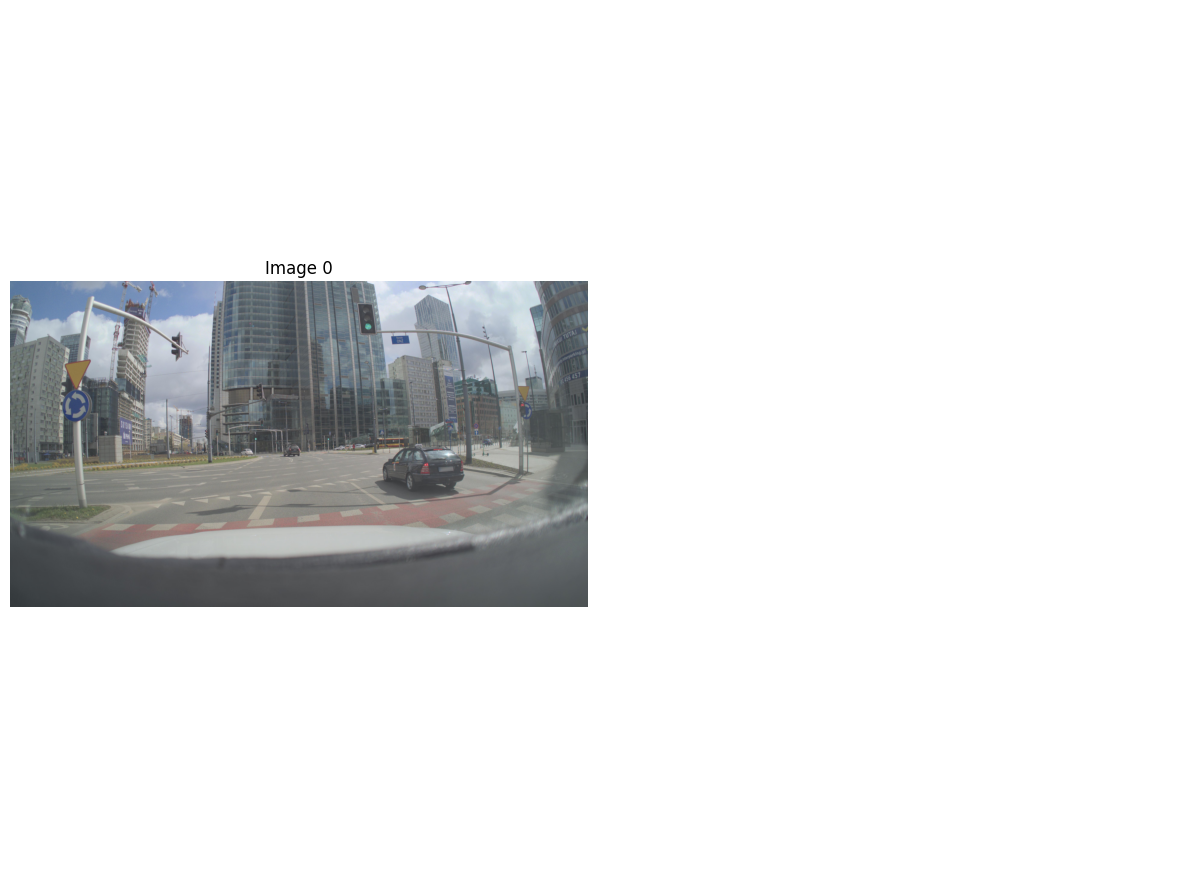

In [7]:
image_dir = './images/bt1'
data_loader = DataLoader(image_dir)

# paths are ./images/bt1/{index}, i want a list of indexes of dirs in that directory NO IMAGES
indices = [int(d) for d in os.listdir(image_dir) if d.isdigit()]
images = []

for idx in indices:
    image = data_loader.load(idx)
    images.append(image)

plot_images(images, grid_shape=(1, 2))

## Visualización de regiones de interés

Además de cargar las imágenes, es importante visualizar las regiones de interés (ROIs) que contienen las señales de tráfico, esto nos servirá para verificar más adelante nuestro procesado de imágenes. Utilizando el cargador implementado, podemos cargar una imagen y sus ROIs asociadas, y luego dibujar las ROIs sobre la imagen para su visualización. A continuación, se muestra un ejemplo de cómo hacerlo:

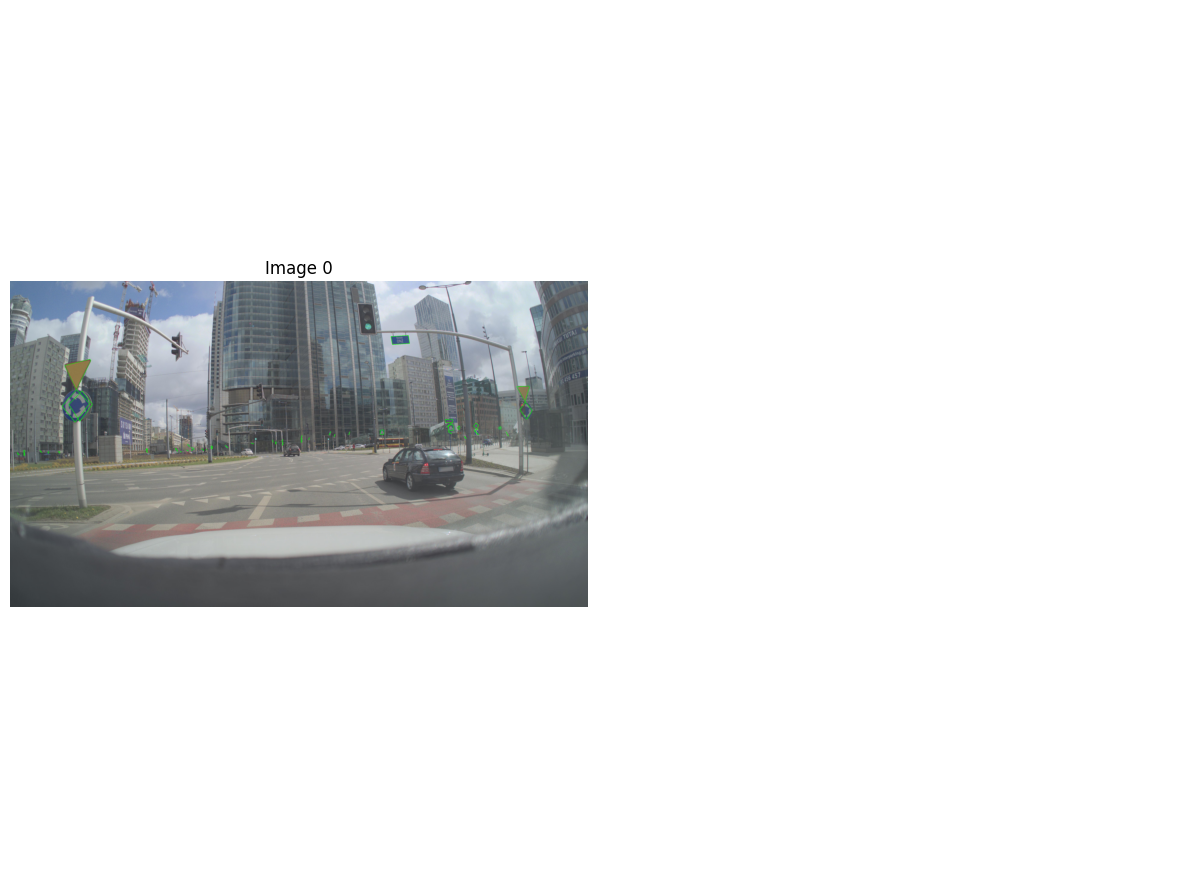

In [8]:
for image in images:
    image.show_rois()

plot_images(images, grid_shape=(1, 2))

In [ ]:
Se puede observar como el etiquetado no es perfecto, ya que algunas señales no están completamente dentro de las regiones de interés (ROIs) definidas.
Sin embargo, para los propósitos de esta práctica, consideraremos que las ROIs son suficientemente buenas para permitirnos más adelante analizar nuestra 
técnica de detección y reconocimiento de señales de tráfico.

# 4. Procesado de imágenes

## 4.1. La clase ImageProcessor

Para facilitar el procesado de imágenes, se ha implementado la clase `ImageProcessor`, que permite encadenar múltiples operaciones de procesado de imágenes de manera sencilla y modular. Esta clase utiliza el patrón de diseño "Builder", lo que permite añadir diferentes filtros y transformaciones a una imagen de forma fluida. A continuación, se muestra un ejemplo de cómo utilizar esta clase para aplicar una serie de transformaciones a una imagen:

## 4.2. Corrección de la distorsión

Observese como la imagen original presenta la distorsión típica de una lente de ojo de pez, ya que se pretende maximizar el campo de visión de la cámara. Afortunadamente, el dataset incluye los parámetros de calibración de la cámara. Para corregir esta distorsión, es necesario aplicar el algoritmo de corrección de distorsión de Kannala-Brandt, que utiliza los parámetros de calibración para mapear los píxeles de la imagen distorsionada a sus posiciones correctas en una imagen sin distorsión. La implementación de este algoritmo implementado en C se encuentra en la función `kannala_brandt_undistort` del módulo `src/dgst/filters/ffi/kannala.c`. A continuación, se muestra un ejemplo de cómo aplicar esta corrección a una imagen del dataset.

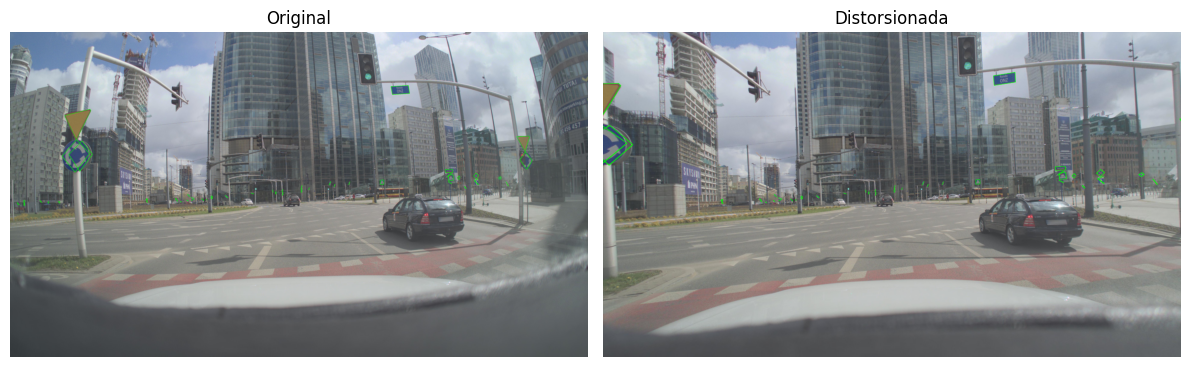

In [11]:
images_distortion = [images[0]]

processor = (ImageProcessor()
        .add_kannala_brandt_undistortion())

images_distortion.append(processor.process(images[0]))
plot_images(images_distortion, titles=["Original", "Distorsionada"], grid_shape=(1, 2))

Observese que, aun manteniendo la resolución original de la imagen, la distorsión ha sido corregida satisfactoriamente, 
sacrificando únicamente una pequeña parte de la imagen en los bordes. Observese como el salpicadero del coche ya no se ve curvado, 
y las líneas de la carretera son rectas en lugar de curvas.